The S1210 airfoil was designed for high lift coefficients at low Reynolds numbers, which seems to be of interest for vertical axis wind turbine applications [1, 2]. A slotted variant for VAWTs was analyzed in a wind tunnel and using CFD [3], where the data for this notebook came from. The experimental data is not really close to the results below (which predict  higher lift and lower drag) nor is the experimental data close to the CFD results in paper. Which, interestingly, predict lower lift and higher drag. Looks like a fully turbulent simulation though.

Regardless, this is an interesting example to show what virtual displacements are good for. They are used to modify smooth geometries to model kinks or otherwise difficult geometries.

In addition, this notebook shows how to interactively plot and show the changes in the solution during the Newton iterations.

<IPython.core.display.Javascript object>


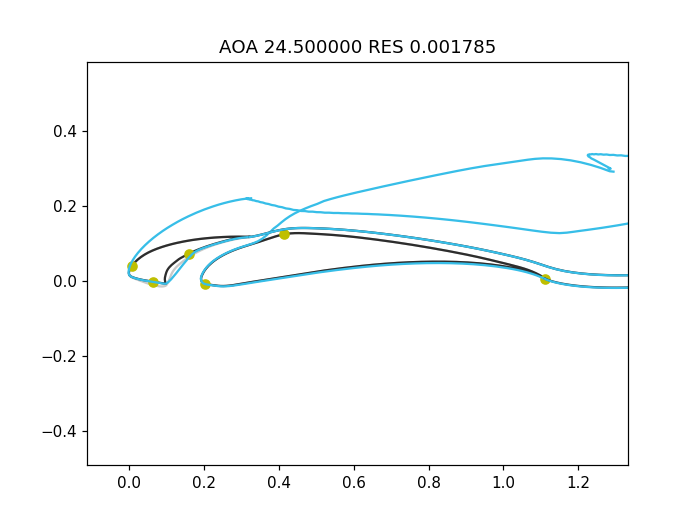

In [1]:
%matplotlib notebook
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import matplotlib.pyplot as plt
import numpy as np

# Make a plot that will be updated interactively
lines = None
fig,ax = plt.subplots(1,1)

In [2]:
SCALE = 0.9 # Scale Geometry to be comparable to base airfoils
BASE = vft.repanel_spline(vft.read_selig("S1210Base.dat"),160)/SCALE
SLOT = vft.repanel_spline(vft.read_selig("S1210Slot.dat"),160)/SCALE
SLOT0 = vft.read_selig("S1210Slot0.dat")/SCALE # Actual slot shape


# Virtual displacement
[vdSlot,SLOTD] = vft.virtual_displacement_from_geometry(SLOT,SLOT0)
vdSlot[0] = 0.0
vdSlot[-1] = 0.0

AOARANGE = np.arange(10,25,0.5)
#AOARANGE = np.arange(10,-10,-0.5)

# Setup
RE = 100000
ncrit = 5
Mach = 0.0
AOA0 = AOARANGE[0]
s = vf.setup(Re=RE,Ma=Mach,ncrit=ncrit,alpha=AOA0)
s.iterate_wakes = False
s.itermax = 1
s.silent = True
s.pitch_rate = 0*90*np.pi/180*0.67/15
#s.pitch_rate = -90*np.pi/180*0.67/15

BASE[1,:]-=.5
SLOT[1,:]-=.5

# Set-up and initialize based on inviscid panel solution
(p,bl,x) = vf.init([BASE,SLOT],s)

xn = x.copy()
alv = []
clv = []
cdv = []

#vfp.plot_geometry(ax,[BASE,SLOT,p.wakes[0].X,p.wakes[1].X],lines,
#                    [bl[0].bl_fl.nodes.delta,bl[1].bl_fl.nodes.delta,-bl[0].bl_wk.nodes.delta,-bl[1].bl_wk.nodes.delta],
#                    [None,vdSlot,None,None])
#error()
for alpha in AOARANGE:
    s.alpha = alpha
    res = None
    grad = None
    for k in range(int(100/s.itermax)): # Make effectively 100 iterations, but show some in between
        [xn,flag,res,grad,_] = vf.iter(xn,bl,p,s,res,grad,[None,vdSlot])
        # Plot geometry
        lines = vfp.plot_geometry(ax,p,bl,lines)
        nres=np.sqrt(np.dot(res.T,res))
        title = "AOA %f RES %f"%(alpha,nres)
        ax.set_title(title)
        #ax.set_xlim([-.1,2.7])
        fig.canvas.draw()
        if nres<2e-3:
            alv.append(alpha)
            clv.append(p.CL)
            cdv.append(bl[0].CD+bl[1].CD)
            print('AL: %f CL: %f CD: %f' % (alpha,clv[-1],cdv[-1]) ) 
            break


AL: 10.000000 CL: 2.115111 CD: 0.045523
AL: 10.500000 CL: 2.167367 CD: 0.046998
AL: 11.000000 CL: 2.216967 CD: 0.048744
AL: 11.500000 CL: 2.267857 CD: 0.050446
AL: 12.500000 CL: 2.363191 CD: 0.053605
AL: 13.000000 CL: 2.410701 CD: 0.055638
AL: 13.500000 CL: 2.457125 CD: 0.057612
AL: 14.000000 CL: 2.504482 CD: 0.059988
AL: 14.500000 CL: 2.550383 CD: 0.062763
AL: 15.000000 CL: 2.597661 CD: 0.066954
AL: 15.500000 CL: 2.640995 CD: 0.072649
AL: 16.000000 CL: 2.690981 CD: 0.079597
AL: 16.500000 CL: 2.742482 CD: 0.087280
AL: 17.000000 CL: 2.786931 CD: 0.095573
AL: 17.500000 CL: 2.833055 CD: 0.103775
AL: 18.000000 CL: 2.868233 CD: 0.114241
AL: 18.500000 CL: 2.901348 CD: 0.124629
AL: 19.000000 CL: 2.910058 CD: 0.136558
AL: 19.500000 CL: 2.919989 CD: 0.150610
AL: 20.000000 CL: 2.912835 CD: 0.166389
AL: 20.500000 CL: 2.890190 CD: 0.189424
AL: 22.500000 CL: 2.246637 CD: 0.395681
AL: 23.000000 CL: 2.203171 CD: 0.418650
AL: 23.500000 CL: 2.196721 CD: 0.443920
AL: 24.000000 CL: 2.205377 CD: 0.471284


<IPython.core.display.Javascript object>


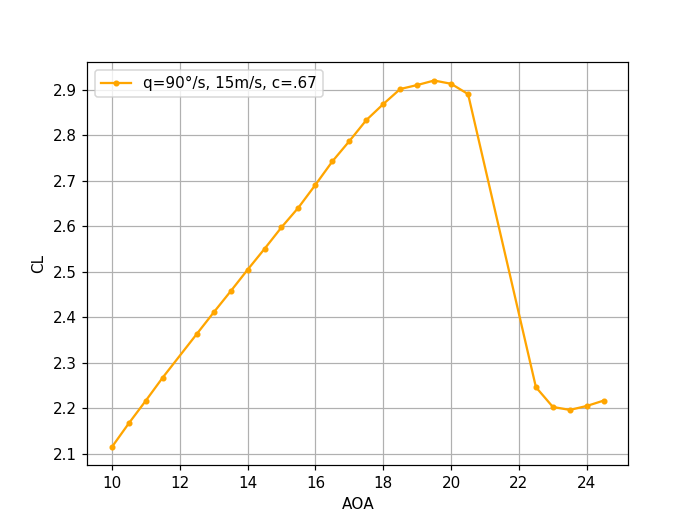

<IPython.core.display.Javascript object>


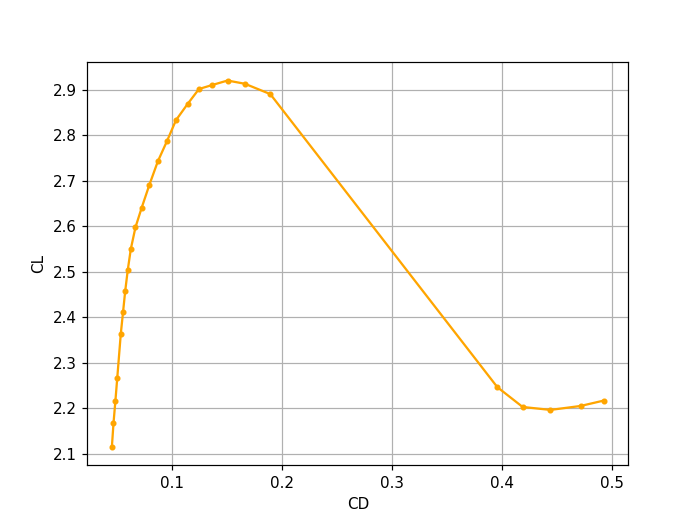

In [3]:
# Make a new plot with the results
fig,ax = plt.subplots(1,1)
ax.plot(alv,clv,marker=".",color="orange")
#ax.plot(backup[0],backup[1],marker=".")
#ax.plot(backup_pitch1[0],backup_pitch1[1],marker=".",color="orange")
ax.set_xlabel('AOA')
ax.set_ylabel('CL')
ax.legend(['q=90°/s, 15m/s, c=.67','q=0°/s'])
ax.grid(1)
fig,ax = plt.subplots(1,1)
ax.plot(cdv,clv,marker=".",color="orange")
#ax.plot(backup[2],backup[1],marker=".")
#ax.plot(backup_pitch1[2],backup_pitch1[1],marker=".",color="orange")
ax.set_xlabel('CD')
ax.set_ylabel('CL');
#ax.legend(['q=0°/s','q=90°/s, 15m/s, c=.67'])
ax.grid(1)

In [ ]:
backup=[alv.copy(),clv.copy(),cdv.copy()]

In [6]:
type(s) is type(vf.setup())

True

[1] Islam, Mazharul, et al. *Investigation of low reynolds number airfoils for fixed-pitch straight-bladed VAWT.* 47th AIAA Aerospace Sciences Meeting including The New Horizons Forum and Aerospace Exposition. 2009.

[2] Singh, M. A., A. Biswas, and R. D. Misra. *Investigation of self-starting and high rotor solidity on the performance of a three S1210 blade H-type Darrieus rotor.* Renewable energy 76 (2015): 381-387.

[3] Chougule, Prasad, and Søren RK Nielsen. *Simulation of flow over double-element airfoil and wind tunnel test for use in vertical axis wind turbine.* Journal of Physics: Conference Series. Vol. 524. No. 1. IOP Publishing, 2014.